In [1]:
from ugropy import unifac, Groups, FragmentationModel

import numpy as np

from rdkit import Chem

from itertools import combinations, product

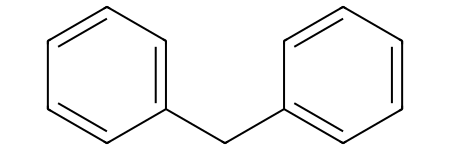

In [93]:
groups = Groups("C(C1=CC=CC=C1)C1=CC=CC=C1", "smiles")

groups.chem_object

In [94]:
groups.unifac_groups

{'ACH': 10, 'ACCH2': 1, 'AC': 1}

In [74]:
def fit_atoms(mol_object: Chem.rdchem.Mol, subgroups: dict, model: FragmentationModel):
    total_atom_num = len(list(groups.chem_object.GetAtoms()))

    # Getting true smarts, this will not be necessary later
    smarts = {}
    for group in subgroups.keys():
        s = model.subgroups.loc[group, "true_smarts"]

        if s is np.nan:
            s = model.subgroups.loc[group, "smarts"]

        smarts.update({group: s})

    # getting atoms candidates for each group
    atoms = {}
    for group, smts in smarts.items():
        atom = mol_object.GetSubstructMatches(Chem.MolFromSmarts(smts))
        atoms.update({group: atom})

    # Getting combinations for each group
    combs = {}
    for group in subgroups.keys():
        group_comb = {group : list(combinations(atoms[group], subgroups[group]))}
        combs.update(group_comb)
    
    # Combination of possible solutions
    llaves = list(combs.keys())
    tuplas_externas = [combs[key] for key in llaves]

    # Generar todas las combinaciones posibles
    sol_combinations = []
    for combinacion in product(*tuplas_externas):
        sol_comb_dict = {llaves[i]: combinacion[i][0] if len(combinacion[i]) == 1 else combinacion[i] for i in range(len(llaves))}
        sol_combinations.append(sol_comb_dict)

    for comb in sol_combinations:
        array_plano = np.concatenate([np.array(comb[llave]).flatten() for llave in comb.keys()])
        unique = np.unique(array_plano)

        if len(unique) == total_atom_num:
            return comb

    return {}


In [95]:
atoms = fit_atoms(groups.chem_object, groups.unifac_groups, unifac)

atoms

{'ACH': ((2,), (3,), (4,), (5,), (6,), (8,), (9,), (10,), (11,), (12,)),
 'ACCH2': (1, 0),
 'AC': (7,)}

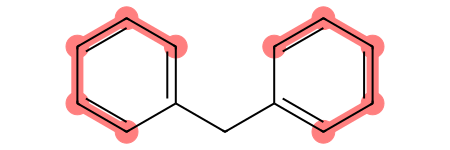

In [112]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

# http://rdkit.blogspot.com/2015/02/new-drawing-code.html

def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc, highlightAtoms=np.array(atoms["ACH"]).flatten().tolist()) # highlightAtoms=[6,12,13]) you can highlight atoms
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

SVG(moltosvg(groups.chem_object))
